# Transfer Learning from ImageNet
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
These two major transfer learning scenarios look as follows:

- **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
for feature extractor we must freeze the parameter by making requires_grad to false
for param in model.parameters():
    param.requires_grad = False

In [55]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import torchvision.models as models
import numpy as np

In [56]:
#we added the resize and the centercrop to prepaer the images for the alexnet
transform=transforms.Compose([transforms.Resize(224),
                              #transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(
                              mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                              )])

In [57]:
batch_size=4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [58]:

# get some random training imatplotlibs
dataiter = iter(trainloader)
images, labels = dataiter.next()

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


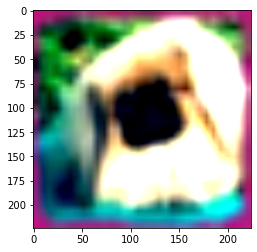

dog


In [59]:
def imshow(img):
    """"this function take a tensor image, unormalize it then converted it numpy format"""
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# show images
imshow(images[0])
# print labels

print(classes[labels[0].item()])

In [60]:
#transfer learning with alexnet

In [61]:
alexnet=models.alexnet(pretrained=True)

In [62]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 



**Note** for the CIFAR10,there will be 10 output class labels to be predicted by the network. For this purpose, we need to update the network because we can see in the above image, the final classifier label that is (6): Linear() is having the 1000 nodes at the output layer. This must be changed to 10. Along with this, we can see a very large number of nodes in the dense layers of the network (see the input and output features in the Linear() under classifier). This may cause the network to overfit or having heavy losses during the training. For this purpose, we will update the structure of each classifier using the below lines of codes.

In [63]:

alexnet.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
alexnet.classifier[6] = nn.Linear(1024,10)

In [64]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)#smaller learning rate or check validation loss 
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
        

print('Finished Training')

[1,  2000] loss: 0.962
[1,  4000] loss: 0.713
[1,  6000] loss: 0.645
[1,  8000] loss: 0.602
[1, 10000] loss: 0.580
[1, 12000] loss: 0.552
[2,  2000] loss: 0.457
[2,  4000] loss: 0.442
[2,  6000] loss: 0.471
[2,  8000] loss: 0.443
[2, 10000] loss: 0.466
[2, 12000] loss: 0.472
[3,  2000] loss: 0.334
[3,  4000] loss: 0.362
[3,  6000] loss: 0.372
[3,  8000] loss: 0.380
[3, 10000] loss: 0.401
[3, 12000] loss: 0.382
[4,  2000] loss: 0.292
[4,  4000] loss: 0.328
[4,  6000] loss: 0.328
[4,  8000] loss: 0.332
[4, 10000] loss: 0.331
[4, 12000] loss: 0.351
[5,  2000] loss: 0.261
[5,  4000] loss: 0.282
[5,  6000] loss: 0.308
[5,  8000] loss: 0.287
[5, 10000] loss: 0.312
[5, 12000] loss: 0.302
[6,  2000] loss: 0.235
[6,  4000] loss: 0.269
[6,  6000] loss: 0.271
[6,  8000] loss: 0.282
[6, 10000] loss: 0.284
[6, 12000] loss: 0.296
[7,  2000] loss: 0.206
[7,  4000] loss: 0.244
[7,  6000] loss: 0.255
[7,  8000] loss: 0.251
[7, 10000] loss: 0.268
[7, 12000] loss: 0.258
[8,  2000] loss: 0.232
[8,  4000] 

In [66]:
#test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


# feature extructer

In [68]:
alexnet=models.alexnet(pretrained=True)
alexnet.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
alexnet.classifier[6] = nn.Linear(1024,10)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

for param in alexnet.features.parameters():
    param.requires_grad = False
    
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.901
[1,  4000] loss: 0.707
[1,  6000] loss: 0.668
[1,  8000] loss: 0.659
[1, 10000] loss: 0.619
[1, 12000] loss: 0.625
[2,  2000] loss: 0.512
[2,  4000] loss: 0.509
[2,  6000] loss: 0.531
[2,  8000] loss: 0.525
[2, 10000] loss: 0.520
[2, 12000] loss: 0.518
[3,  2000] loss: 0.432
[3,  4000] loss: 0.459
[3,  6000] loss: 0.439
[3,  8000] loss: 0.445
[3, 10000] loss: 0.445
[3, 12000] loss: 0.456
[4,  2000] loss: 0.372
[4,  4000] loss: 0.375
[4,  6000] loss: 0.382
[4,  8000] loss: 0.392
[4, 10000] loss: 0.383
[4, 12000] loss: 0.418
[5,  2000] loss: 0.330
[5,  4000] loss: 0.336
[5,  6000] loss: 0.328
[5,  8000] loss: 0.336
[5, 10000] loss: 0.354
[5, 12000] loss: 0.362
Finished Training


In [70]:
#test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


Explain what is the difference between the two runs and why there is a difference in performance,

- In the first Approach,**fine-tuning** we allow all weights to be changed during the training phase.
- while in the second one,**feature extractor**,we instead freeze earlier layers of the model, 
which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced.
 
This works because low level information extracted from the input image is universal between tasks, examples of such information is edge detection,
shape detection and pattern detection. This is what the early layers are optimized to do, as where later layers extract more abstract features relevant for the task.

- **Feature extrucion is defiantly faster than fine tuning, because we only train the last layers**